<h1><center>IPCV Project (Fruit Inspection)</center></h1>
<center>Students should develop a software system aimed at locating defects and imperfections on fruits.</center>
<br>

<h3><center>By: Gee Jun Hui Leonidas Yunani</center></h3>
<center>Email: leonidas.gee@studio.unibo.it</center>
<center>Academic Year: 2020 / 2021</center>

## Overall Task
Students should develop a software system aimed at locating defects and imperfections on fruits. Each fruit is acquired through a NIR (Near Infra-Red) and a color camera with little parallax effect.

In [1]:
# Import the necessary libraries
import cv2
import numpy as np
from scipy.spatial.distance import mahalanobis
import matplotlib.patches as patches
from matplotlib import pyplot as plt
%matplotlib inline

## First Task: Fruit Segmentation and Defect Detection

Students should:
- Outline the fruit by generating a binary mask
- Search for the defects on each fruit

In [2]:
# Define the load images function
def loadImg(loc, img_lst, colour=None):
    plt.figure(figsize=(15, 15))
    
    # Number of rows required per 3 images
    num_img = len(img_lst)
    row = int(np.ceil(num_img / 3))
    
    load_lst = []
    for i, img in enumerate(img_lst):       
        # Read and plot gray or coloured image
        plt.subplot(row, 3, i+1)
        filename = loc + '/' + img
        
        if colour == 'gray':
            load_img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
            plt.imshow(load_img, 'gray')
        elif colour == 'colour':
            load_img = cv2.imread(filename)
            load_img = cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB)
            plt.imshow(load_img)
            
        load_lst.append(load_img)
        
    return load_lst

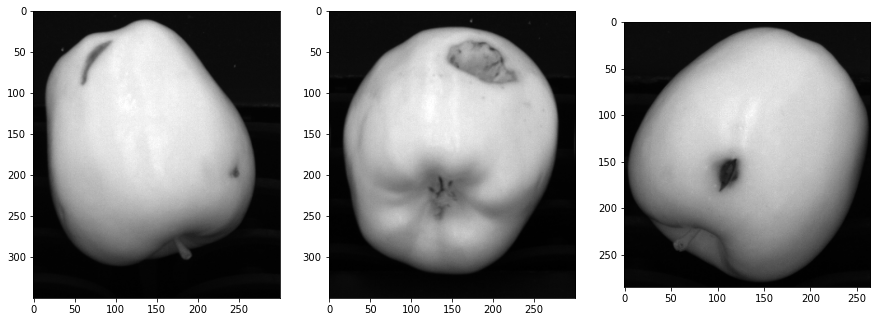

In [3]:
# Load images for task 1 as grayscale
images = loadImg('dataset/first task', 
                 ['C0_000001.png', 'C0_000002.png', 'C0_000003.png'], 
                 'gray')

## Outline the fruit by generating a binary mask

Otsu's thresholding is implemented with a bias that defaults to 1 if no value is given. The bias allows the adjustment of the thresholding to capture more areas of the defect if needed. However, this may cause the thresholding to also suffer in other areas of the image.

In [4]:
# Define Otsu's thresholding function
def otsuThresh(img_lst, bias=1):
    plt.figure(figsize=(15, 15))

    # Number of rows required per 3 images
    num_img = len(img_lst)
    row = int(np.ceil(num_img / 3))
    
    th_lst = []
    for i, img in enumerate(img_lst):
        th, th_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Adjust the thresholding defined by Otsu using a bias
        desired_th = th * bias
        _, th_img = cv2.threshold(img, desired_th, 255, cv2.THRESH_BINARY)
        th_lst.append(th_img)
        
        plt.subplot(row, 3, i+1)
        plt.imshow(th_img, 'gray')
        
    return th_lst

In the first case, as the outline of the fruit and not the defects is the goal, the images are binarised using Otsu's without a bias. This results in certain defects being imperfectly defined such as in image 2.

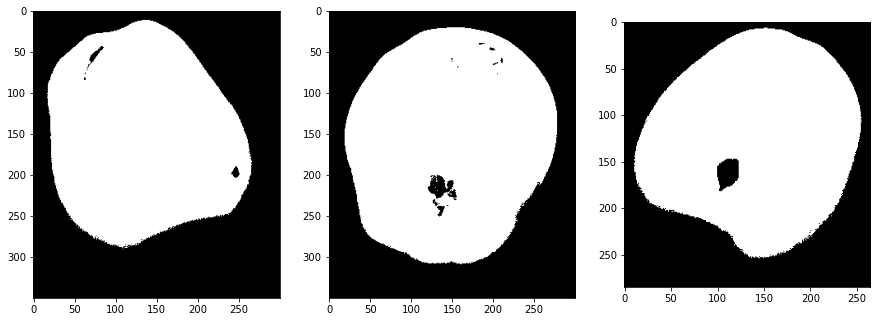

In [5]:
# Threshold the images using Otsu's
binary = otsuThresh(images)

A closing binary morphology is used to reduce as much as possible the areas of the holes in each image. An appropriate sized structuring element must be chosen. For this, a simple 12 by 12 elliptical structuring element is used.

In [6]:
# Define the binary morphology function
def binMorph(img_lst, morph_type, size):
    plt.figure(figsize=(15, 15))

    # Number of rows required per 3 images
    num_img = len(img_lst)
    row = int(np.ceil(num_img / 3))        
    
    # Initialise an elliptical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
    
    if morph_type == 'open':
        morph = cv2.MORPH_OPEN
    elif morph_type == 'close':
        morph = cv2.MORPH_CLOSE
    elif morph_type == 'border':
        morph = cv2.MORPH_GRADIENT
    
    morph_lst = []
    for i, img in enumerate(img_lst):
        # Apply open or close binary morphology
        res = cv2.morphologyEx(img, morph, kernel)
        morph_lst.append(res)
        
        plt.subplot(row, 3, i+1)
        plt.imshow(res, 'gray')
        
    return morph_lst

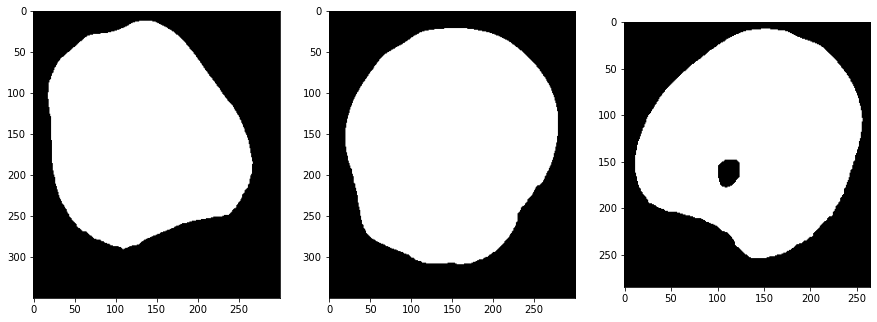

In [7]:
# Use the closing binary morphology operator
morph = binMorph(binary, 'close', 12)

A morphological gradient which is the difference between the dilation and erosion of an image is used to obtain the edges of the fruits. For this a 3 by 3 elliptical structuring element is used.

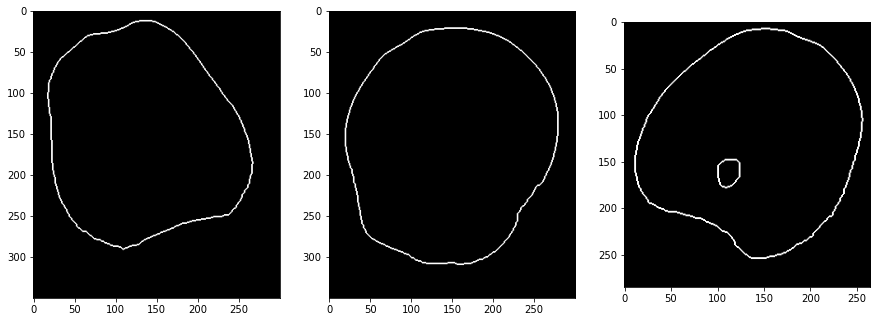

In [8]:
# Use the gradient binary morphology operator
edges = binMorph(morph, 'border', 3)

## Search for the defects on each fruit

Utilising a bias of 1.4, a new threshold is computed to binarise the image. The bias better captures the defect especially in image 2. However, it also distorts other parts of the outline particularly at the bottom of image 2.

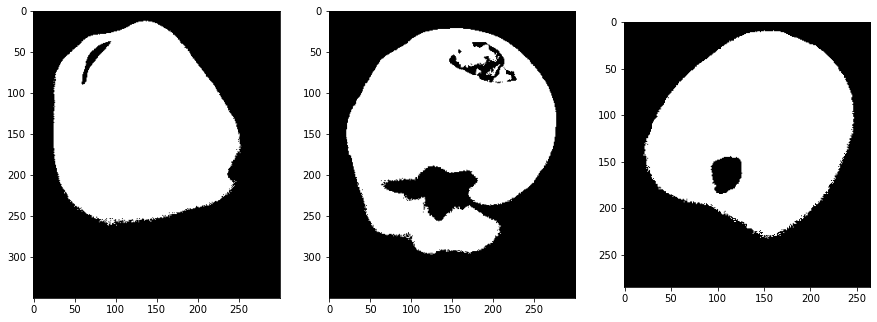

In [9]:
# Threshold the images using Otsu's with a bias
binary = otsuThresh(images, 1.4)

An opening binary morphology is used to remove small objects from the foreground for further component labelling. In this case, a 10 by 10 elliptical structuring element is used.

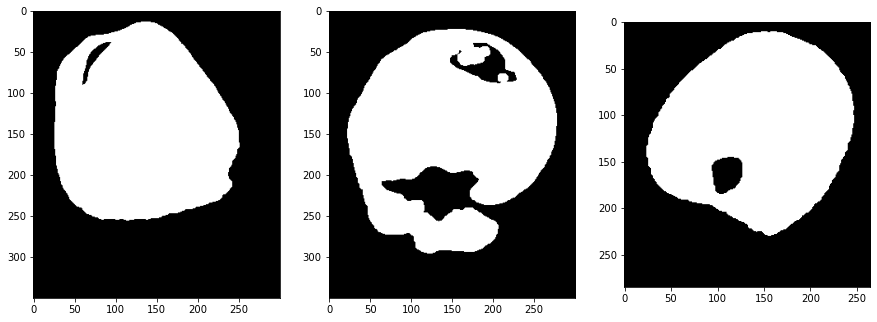

In [10]:
# Use the opening binary morphology operator
morph = binMorph(binary, 'open', 10)

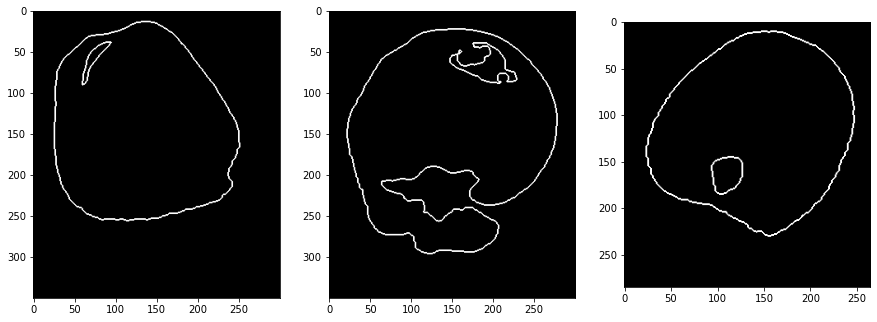

In [11]:
# Use the gradient binary morphology operator
edges = binMorph(morph, 'border', 3)

Component labelling can be used to remove irrelevent edges that do not highlight the defects or at least parts of it. Since each component consists of a certain number of pixels, a threshold can be set to only keep components whose number of pixels are within an acceptable range (MIN to MAX).

In [12]:
# Define the component labelling function
def compLabel(img, min_n, max_n):
    plt.figure(figsize=(10, 10))    
    
    _, labels = cv2.connectedComponents(img)
    
    def colourLabel(labels):
        # Map component labels to hue val
        label_hue = np.uint8(179 * labels / (np.max(labels)+1))
        blank_ch = 255 * np.ones_like(label_hue)
        labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

        # Convert to BGR for display
        labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

        # Set background label to black
        labeled_img[label_hue==0] = 0
        return labeled_img
    
    # Plot all initial component labels
    plt.subplot(1, 2, 1)
    plt.imshow(colourLabel(labels))   
    
    # Keep component labels whose number of pixels is between the given range
    num = labels.max()
    for j in range(1, num + 1):
        pts =  np.where(labels == j)
        if len(pts[0]) < min_n or len(pts[0]) > max_n:
            labels[pts] = 0
    
    # Plot all reduced component labels
    plt.subplot(1, 2, 2)
    plt.imshow(colourLabel(labels))        
        
    return labels

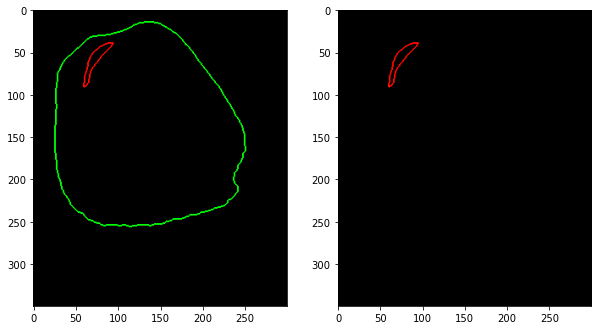

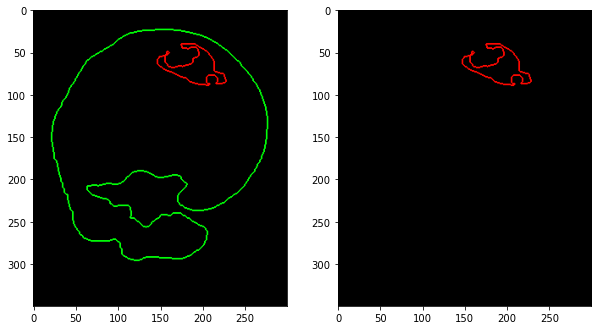

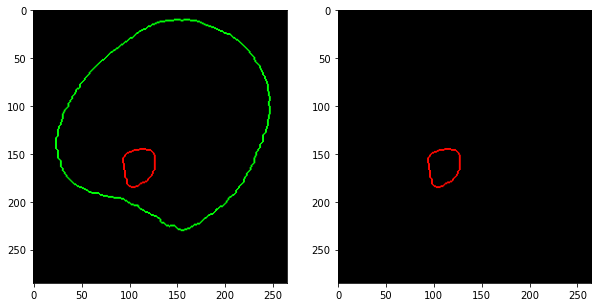

In [13]:
# Label all the edges as components and reduce them using a range threshold
labels = []
for edge in edges:
    labels.append(compLabel(edge, 0, 600))

The reduced number of component labels can be used to define the bounding box of the approximate location of the defect. However, depending on the initial thresholding, certain defects might not be definable such as the defect on the lower right corner of image 1.

In [14]:
# Define the show defects function
def showDefects(img_lst, edg_lst, lbl_lst):
    plt.figure(figsize=(15, 15))    
    
    # Number of rows required per 3 images
    num_img = len(img_lst)
    row = int(np.ceil(num_img / 3))      
    
    for n in range(num_img):
        shape = img_lst[n].shape
        copy_img = img_lst[n].copy()
        
        # Plot the original image which will be drawn upon
        ax = plt.subplot(row, 3, n+1)
        if len(shape) == 2:
            plt.imshow(copy_img, 'gray')
        elif len(shape) == 3:
            plt.imshow(copy_img)        

        copy_edg = edg_lst[n].copy()            
            
        for j in range(shape[0]):
            for i in range(shape[1]):
                # Plot the contours of the reduced component labels
                if lbl_lst[n][j, i] != 0:
                    plt.plot(i, j, 'b.', markersize=1)
                
                # Remove irrelevent edges that are not needed for computing the bounding box
                elif lbl_lst[n][j, i] == 0:
                    copy_edg[j, i] = 0
        
        # Compute the top-left corner and dimensions of the bounding box
        x, y, w, h = cv2.boundingRect(copy_edg)
        
        # Draw the bounding box around the approximate defect location
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

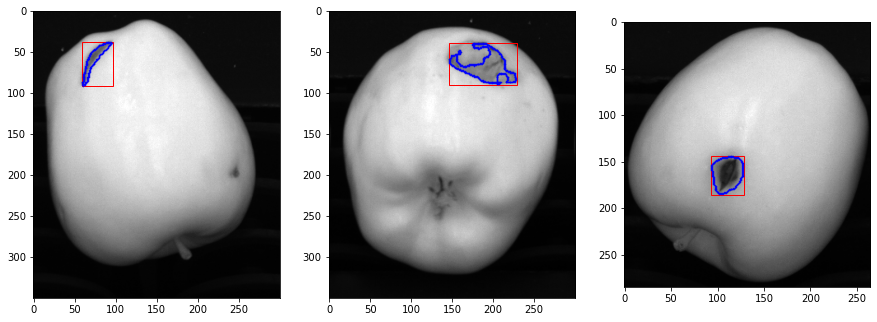

In [15]:
# Show all detected defects in the original images
showDefects(images, edges, labels)

## Second Task: Russet Detection

Students should identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits.

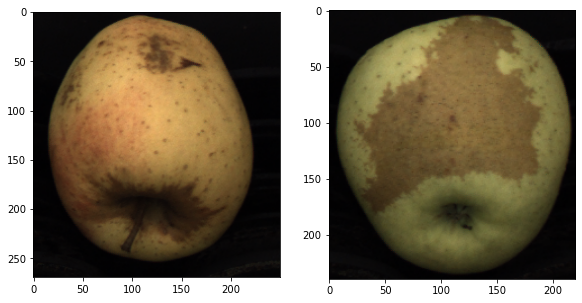

In [16]:
# Load images for task 2
images = loadImg('dataset/second task', 
                 ['C1_000004.png', 'C1_000005.png'], 
                 'colour')

## Identifying the russet or at least some part of it with no false positive areas (if possible)

An area as representative of the foreground (ruset) must be chosen for the calculation of the Mahalanobis distance in the colour segmentation of the image.

In [17]:
# Define the crop area function for finding the foreground median colour
def cropArea(img, left_x, left_y, width, height):
    plt.figure(figsize=(10, 10))     
    
    # Plot the original image which will be drawn upon
    ax = plt.subplot(1, 2, 1)
    plt.imshow(img)
    
    # Draw a rectagular box around the cropped area
    rect = patches.Rectangle((left_x, left_y), width, height, 
                             linewidth=1, edgecolor='orange', 
                             facecolor='none')
    ax.add_patch(rect)    
    
    # Get the cropped area of interest from the original image
    crop_img = img[int(left_y) : int(left_y + height), 
                   int(left_x) : int(left_x + width), :]
    
    # Plot the cropped area
    ax = plt.subplot(1, 2, 2)
    plt.imshow(crop_img)
    
    return crop_img

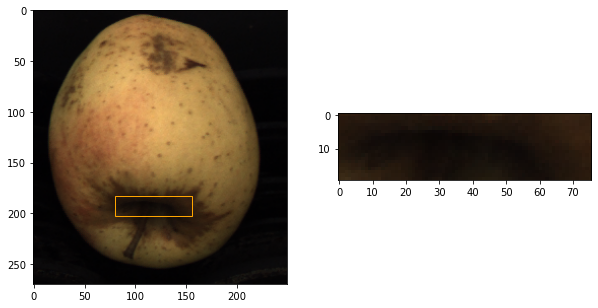

In [18]:
# Crop the area whose colours most represent the foreground (defect)
crop = cropArea(images[0], 80, 183, 76, 20)

A threshold must also be chosen and adjusted to segment the image such that as much of the foreground is captured while leaving out as much of the background.

In [19]:
def segColour(img_lst, crop_img, thresh):
    plt.figure(figsize=(15, 15))
    
    # Number of rows required per 3 images
    num_img = len(img_lst)
    row = int(np.ceil(num_img / 3))     
    
    copy_lst = []
    for n in range(num_img):
        shape = img_lst[n].shape
        copy_img = img_lst[n].copy()

        # Calculate the mean and inverse covariant matrix
        r = crop_img[:, :, 0]
        g = crop_img[:, :, 1]
        b = crop_img[:, :, 2]
        
        M = np.array([r.mean(), g.mean(), b.mean()])
        cov = np.cov(np.mean(crop_img, axis=0).T)
        inv_cov = np.linalg.inv(cov)
        
        # Remove all pixels that do not meet the foreground threshold
        for j in range(shape[0]):
            for i in range(shape[1]):
                if mahalanobis(copy_img[j, i], M, inv_cov) > thresh:
                    copy_img[j, i] = 0
        
        copy_lst.append(copy_img)
        
        # Plot the colour segmented image
        plt.subplot(row, 3, n+1)
        plt.imshow(copy_img)
        
    return copy_lst

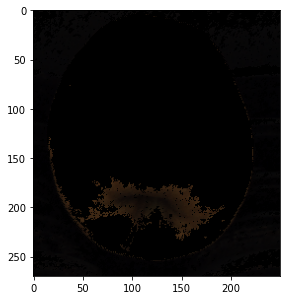

In [20]:
# Threshold the images using the Mahalanobis distance for colour
colour = segColour([images[0]], crop, 6)

Canny's edge detector is used to obtain the edges of the remaining area after colour segmentation. Binary morphology cannot be used here as the image is not binary. 

In [21]:
# Define Canny's edge detection function
def cannyDetect(img_lst):
    plt.figure(figsize=(15, 15))

    # Number of rows required per 3 images
    num_img = len(img_lst)
    row = int(np.ceil(num_img / 3)) 
    
    edg_lst = []    
    for i, img in enumerate(img_lst):
        edges = cv2.Canny(img, 100, 200)
        edg_lst.append(edges)
        
        plt.subplot(row, 3, i+1)
        plt.imshow(edges, 'gray')
        
    return edg_lst

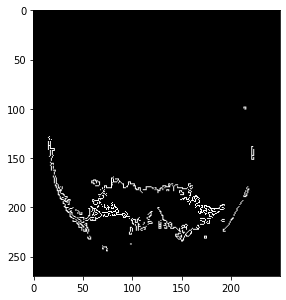

In [22]:
# Detect edges in the colour segmented images
edges = cannyDetect(colour)

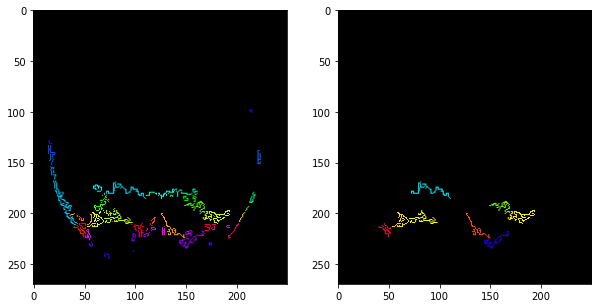

In [23]:
# Label all the edges as components and reduce them using a range threshold
labels = []
for edge in edges:
    labels.append(compLabel(edge, 40, 100))

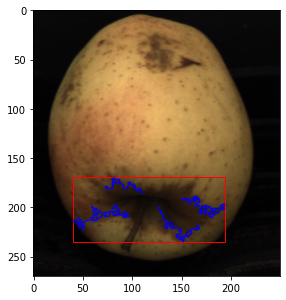

In [24]:
# Show all detected defects in the original image
showDefects([images[0]], edges, labels)

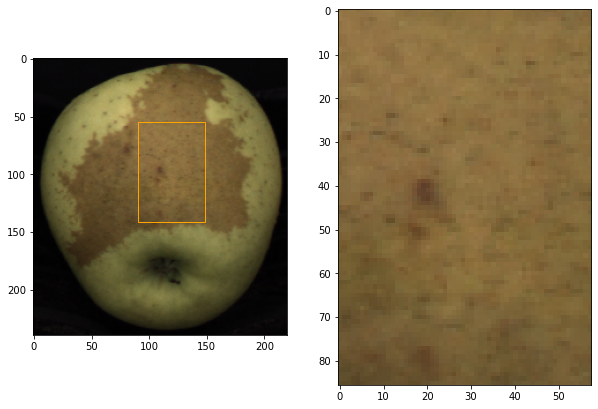

In [25]:
# Crop the area whose colours most represent the foreground (defect)
crop = cropArea(images[1], 90, 55, 58, 86)

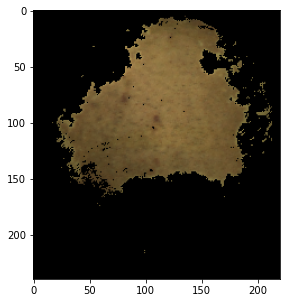

In [26]:
# Threshold the images using the Mahalanobis distance for colourz
colour = segColour([images[1]], crop, 20)

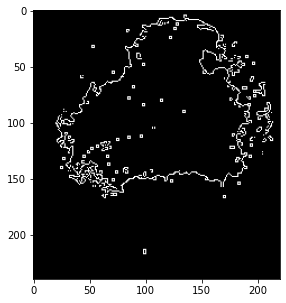

In [27]:
# Detect edges in the colour segmented images
edges = cannyDetect(colour)

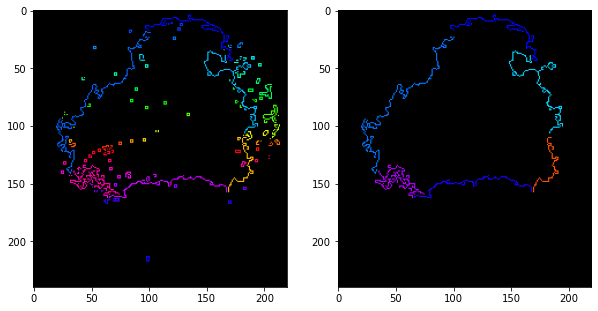

In [28]:
# Label all the edges as components and reduce them using a range threshold
labels = []
for edge in edges:
    labels.append(compLabel(edge, 80, 400))

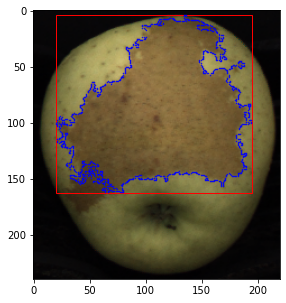

In [29]:
# Show all detected defects in the original image
showDefects([images[1]], edges, labels)

## Final Challenge: Kiwi Inspection

Students should segment the fruits and locate the defect in image “000007”. Special care should be taken to remove as “background” the dirt on the conveyor as well as the sticker in image “000006”.

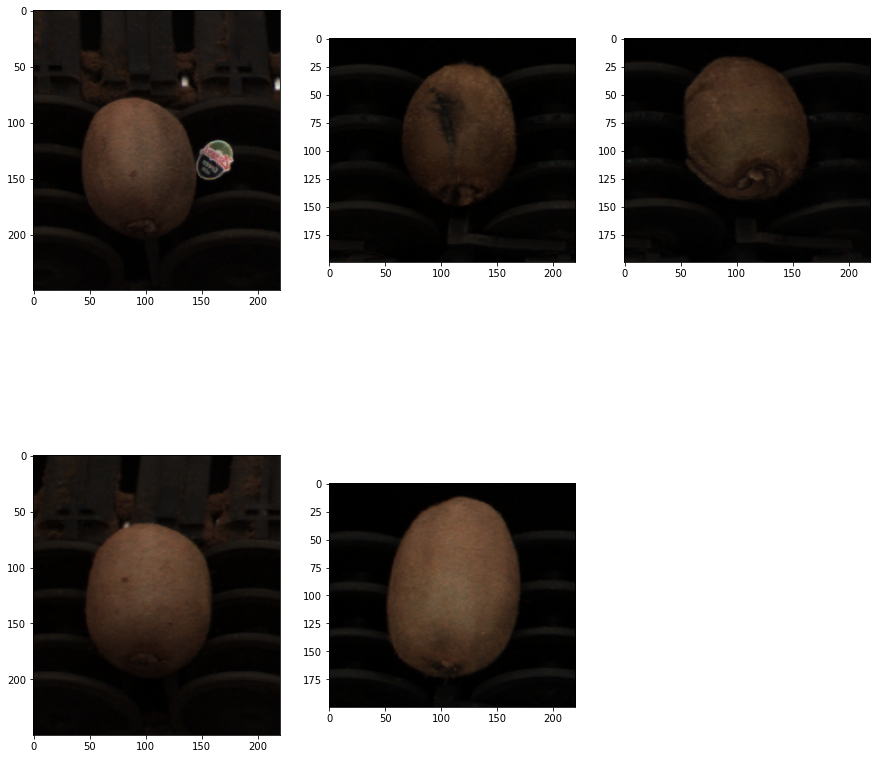

In [30]:
# Load images for task 3
images = loadImg('dataset/final challenge', 
                 ['C1_000006.png', 'C1_000007.png', 'C1_000008.png', 
                  'C1_000009.png', 'C1_000010.png'], 
                 'colour')

## Removing as “background” the dirt on the conveyor as well as the sticker in image “000006”

The given images of the fruits appear to show them to be in relatively similar positions in the centre of the image. The colours of the foreground that must be captured also appear to be relatively similar. Hence, a fixed square around the centre can be used to obtain the cropped areas of interest. These areas are then combined as a stacked matrix for colour segmentation using the Mahalanobis distance later.

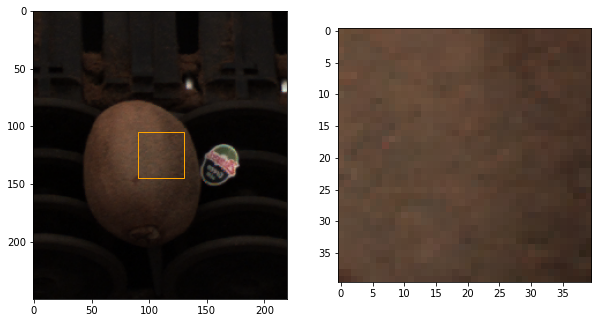

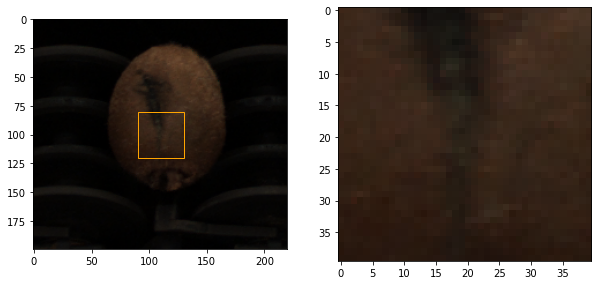

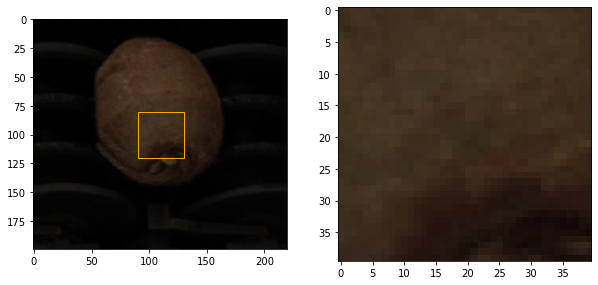

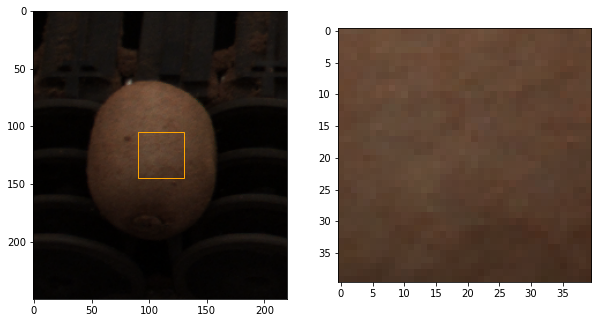

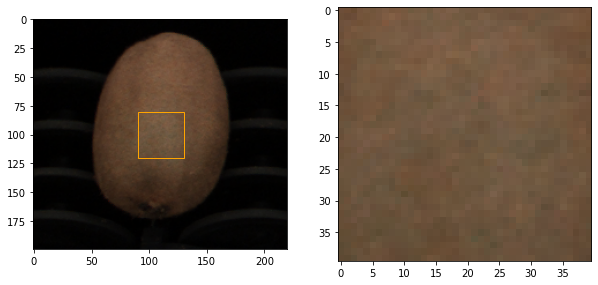

In [31]:
# Crop the area whose colours most represent the foreground (defect)
crop = []
for img in images:
    shape = img.shape
    centres = (shape[1]/2, shape[0]/2)
    crop.append(cropArea(img, centres[0] - 40/2, centres[1] - 40/2, 40, 40))

In [32]:
# Merge all croped images into one stacked matrix
full_crop = crop[0]
for crop_img in crop[1:]:
    full_crop = np.vstack((full_crop, crop_img))
print(full_crop.shape)

(200, 40, 3)


The colour segmented images appear to show most of the background (conveyor) pixels removed including the sticker in image "000006". However, certain false positives still exist in some images along with false negatives in the form of holes in the images.

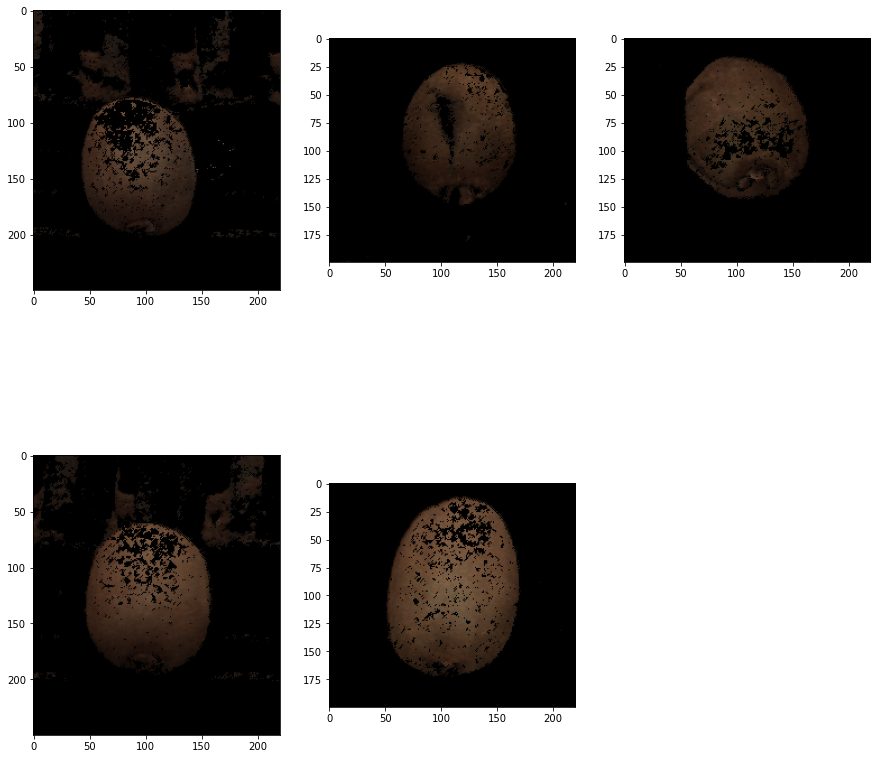

In [33]:
# Threshold the images using the Mahalanobis distance for colour
colour = segColour(images, full_crop, 25)

## Locate the defect in image “000007”

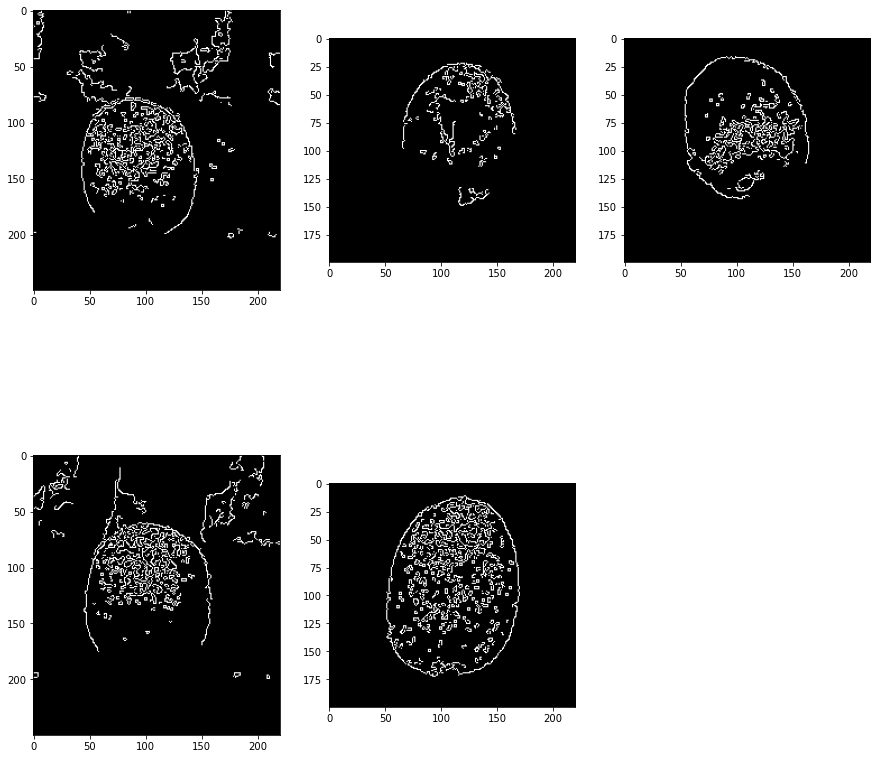

In [34]:
# Detect edges in the colour segmented images
edges = cannyDetect(colour)

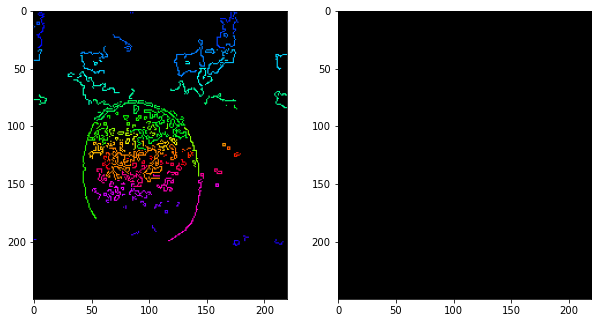

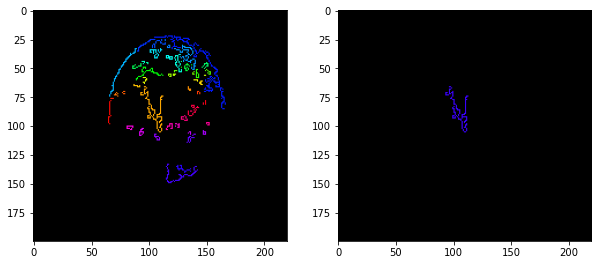

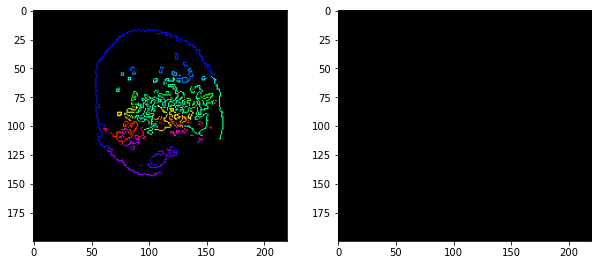

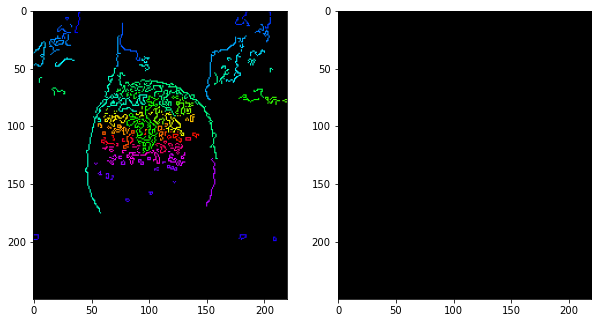

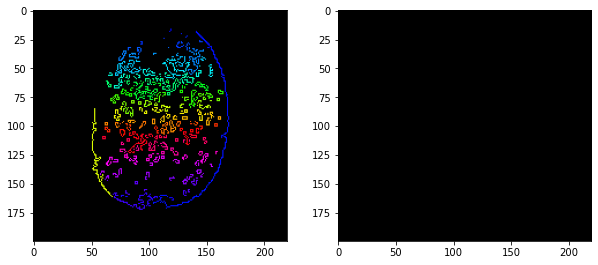

In [35]:
# Label all the edges as components and reduce them using a range threshold
labels = []
for edge in edges:
    labels.append(compLabel(edge, 120, 130))

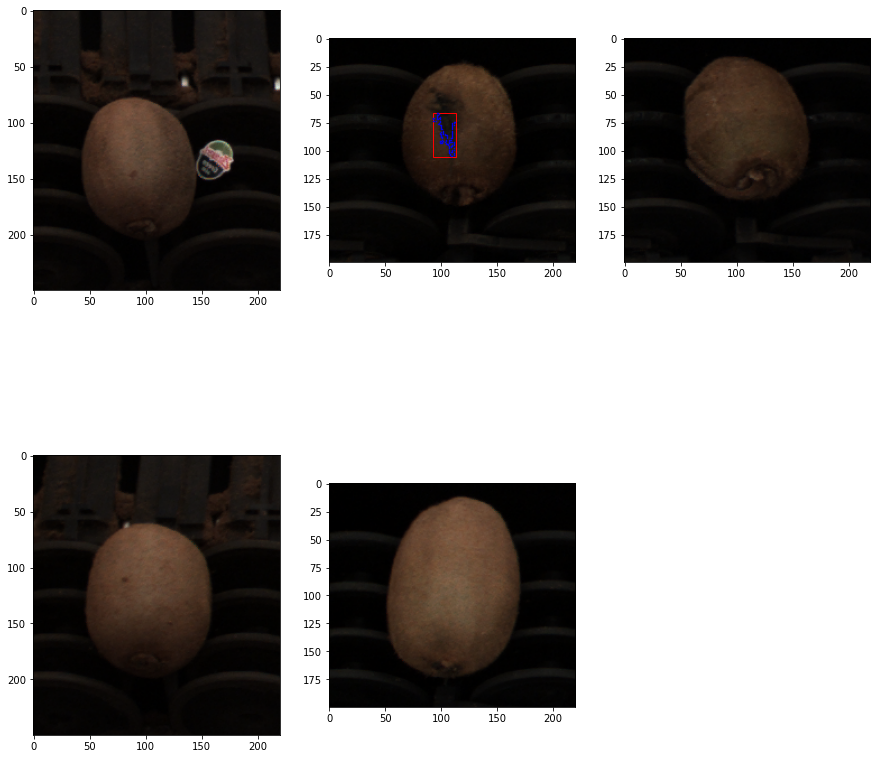

In [36]:
# Show all detected defects in the original images
showDefects(images, edges, labels)

## Conclusion

For this project, a combination of image segmentation, binary morphology, blob analysis and edge detection was used to solve the tasks. The method proposed is able to detect and locate approximately the defects or parts of it on the fruits as shown by the bounding boxes, albeit imperfectly. 

The method relies heavily on thesholds that must be set manually in accordance to the image characteristics. If the image characteristics such as object position or foreground colour (area of interest) are relatively uniform across the images such as in task 1 and 3, a single set of thresholds may be used for the problem.